# Autoencoders

In [1]:
# to avoid dead kernel error when using Pytorch.
import os
os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE"

## Import

In [2]:
import numpy as np
import torch
import torch.nn as nn
import torchvision
import matplotlib.pyplot as plt
from tqdm import tqdm

In [3]:
# GPU?
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [4]:
def plot_latent(h, t_class):
    '''
     Plots the 2D points in h, coloured according to their class.
    '''
    colours = ['pink', 'r', 'orange', 'tab:brown', 'y', 'g', 'teal', 'b', \
               'mediumpurple', 'gray', 'b']

    plt.figure(figsize=(7,6))
    for c in range(10):
        hh = h[t_class==c]
        if len(hh)>0:
            plt.scatter(hh[:,0], hh[:,1], c=colours[c], label=f'{c}')
    plt.axis('square');
    plt.legend(loc=(1.02, 0.5))
    plt.tight_layout();

# Dataset: MNIST

In [5]:
# image size: 28x28, can be 14 for 14x14 images.
img_size = 28

ds_full = torchvision.datasets.MNIST('./files/', train=True, download=True,
                            transform=torchvision.transforms.Compose([
                            torchvision.transforms.Resize((img_size,img_size)),
                            torchvision.transforms.ToTensor(),
                            torchvision.transforms.Lambda((lambda x: torch.flatten(x))),
                            ]))

In [6]:
class MNIST(torch.utils.data.Dataset):
    def __init__(self, n=1024, img_size=28):
        '''
         ds = MNIST(n=1024, img_size=28)
         
         Creates an MNIST dataset of n digit images of the specified size.
         The images are converted to 1D vectors of size (img_size)**2.
        '''
        self.img_size = img_size
        self.n = n
        ds_full = torchvision.datasets.MNIST('./files/', train=True, download=True,
                            transform=torchvision.transforms.Compose([
                            torchvision.transforms.Resize((img_size,img_size)),
                            torchvision.transforms.ToTensor(),
                            torchvision.transforms.Lambda((lambda x: torch.flatten(x))),
                            ]))
        ds_n = torch.utils.data.Subset(ds_full, range(self.n))
        self.x = ds_n

    def __len__(self):
        return len(self.x)
    
    def __getitem__(self, idx):
        '''ds.__getitem__(idx) returns the image and class for a sample.
        '''
        x = self.x[idx][0]
        t = self.x[idx][1]
        return x, t
    
    def draw(self, x=None, idx=None):
        '''ds.draw(x=None, idx=None)
           Draws image x, or the image for index idx. If no argument is
           given, it chooses an index randomly.
        '''
        if x is not None:
            # Do nothing
            pass
        elif idx is not None:
            x = self.x[idx][0]
        else:
            r = np.random.randint(0, high=self.n)
            x = self.x[r][0]
        with torch.no_grad():
            plt.imshow(x.reshape((self.img_size, self.img_size)).detach().numpy(), cmap='gray');
            plt.axis('off');

In [7]:
ds = MNIST()

In [8]:
x, t = ds.__getitem__(12)

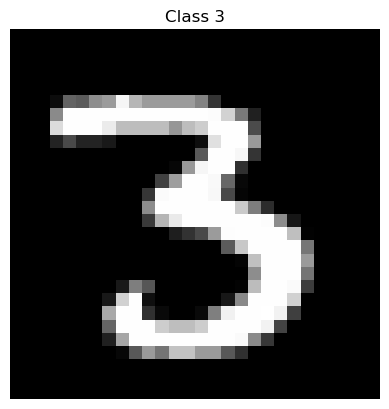

In [9]:
plt.figure()
ds.draw(x=x)
plt.title(f'Class {t}');

## Create some `DataLoader`s

In [10]:
# Batched, for training
batch_size_train = 16
train_dl = torch.utils.data.DataLoader(ds, batch_size=batch_size_train, shuffle=True)

In [11]:
# A single batch, for plotting
train_all = torch.utils.data.DataLoader(ds, batch_size=1024, shuffle=False)

# Autoencoder class

In [12]:
class MyAE(nn.Module):
    '''
     net = MyAE(img_size=28, embedding_dim=2)
     
     Create an autoencoder for imput images of size (img_size x img_size),
     with an embedding (latent) layer of (embedding_dim) neurons.
     
     Inputs:
       img_size       size of input images
                      Input samples will be (img_size**2) vectors.
       embedding_dim  number of nodes in embedding (latent) layer
       
     Usage:
       net = MyAE()
       y = net(x)         # returns output
       h = net.encode(x)  # returns latent vectors
    '''
    def __init__(self, img_size=28, embedding_dim=2):
        self.img_size = img_size
        self.embedding_dim = embedding_dim
        self.losses = []
        super().__init__()
        
        self.encode = nn.Sequential(
            nn.Linear(self.img_size**2, 128),
            nn.ReLU(),
            nn.Linear(128, 32),
            nn.ReLU(),
            nn.Linear(32, 8),
            nn.ReLU(),
            nn.Linear(8, self.embedding_dim)
        )
        
        self.decode = nn.Sequential(
            nn.Linear(self.embedding_dim, 8),
            nn.ReLU(),
            nn.Linear(8, 32),
            nn.ReLU(),
            nn.Linear(32, 128),
            nn.ReLU(),
            nn.Linear(128, self.img_size**2),
            nn.Sigmoid()
        )
        
    def forward(self, x):
        self.h = self.encode(x)
        self.y = self.decode(self.h)
        return self.y

    
    def learn(self, dl, epochs=10, optimizer=None, loss_fcn=None):
        '''
         net.learn(dl, epochs=10, optimizer=None, loss_fcn=None)
         
         Train the network on the dataset delivered by the dataloader dl.
         
         Inputs:
          dl        DataLoader object
          epochs    number of epochs to train
          optimizer PyTorch optimizer function
          loss_fcn  PyTorch loss function
        '''
        if optimizer is None or loss_fcn is None:
            print('Need to specify an optimizer and loss function')
            return

        for epoch in tqdm(range(epochs)):
            total_loss = 0.
            count = 0.
            for x, t in dl:
                #x = x.to(device)   # for use with a GPU
                y = self(x)
                loss = loss_fcn(y, x)
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()
                total_loss += loss.item()*len(t)
                count += 1.
            self.losses.append(total_loss/len(dl.dataset))

        plt.figure(figsize=(6,4))
        plt.plot(self.losses); plt.yscale('log');

# Network training

In [13]:
net = MyAE(img_size=img_size, embedding_dim=2)

100%|██████████████████████████████████████████████████████████████████████████████████| 60/60 [02:09<00:00,  2.15s/it]


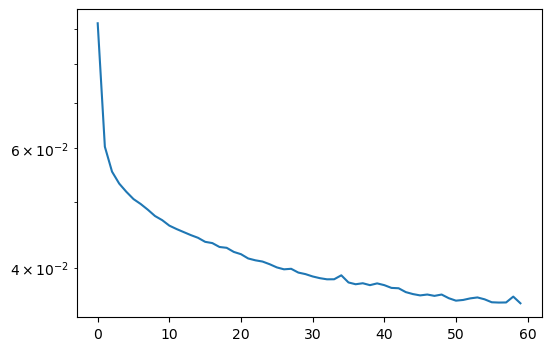

In [14]:
losses = net.learn(train_dl, epochs=60, optimizer= torch.optim.Adam(net.parameters(), lr=0.004, weight_decay=0.000001), loss_fcn = nn.MSELoss())

In [15]:
# Save the network if needed
#torch.save(net.to('cpu'), 'my_AE.pt')

# Reload the network
#net = torch.load('my_AE.pt')
# GPU?
#net.to(device)

# Show the latent space

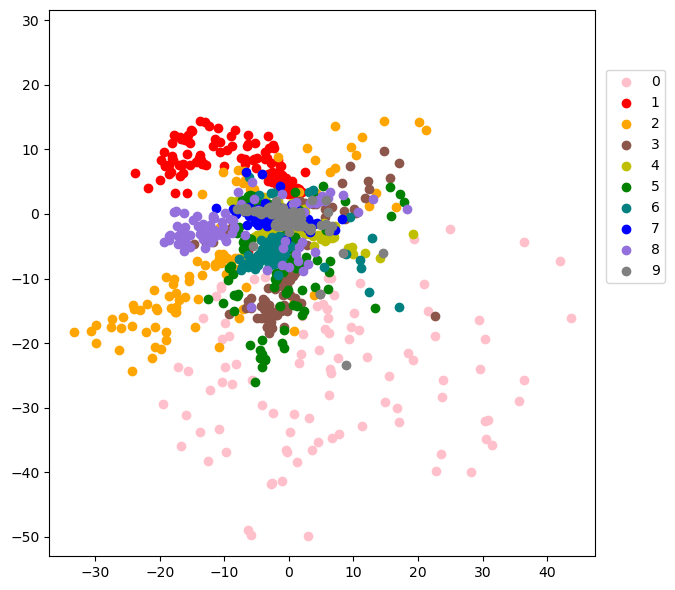

In [16]:
for x, t_class in train_all:
    h = net.encode(x)
plot_latent(h.detach(), t_class)

# Reconstructe digit images

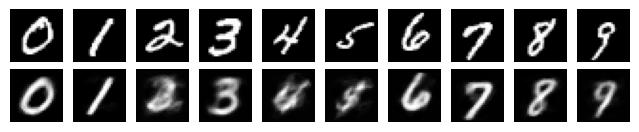

In [17]:
fig = plt.figure(figsize=(8, 4))
plt.subplots_adjust(bottom=0, top=0.3, hspace=0)

cla = 0
for x, t in train_all:
    y = net(x)
    count = 1
    for i in range(len(x)):
        if t[i] == cla:
            fig.add_subplot(2, 10, count)
            ds.draw(x[i])
            fig.add_subplot(2, 10, count + 10)
            ds.draw(y[i])
            cla += 1
            count += 1
        if cla > 9:
            break
        

# Selected Reconstructions

In [18]:
# Save model
#torch.save(net.to('cpu'), 'autoencoder.pt')

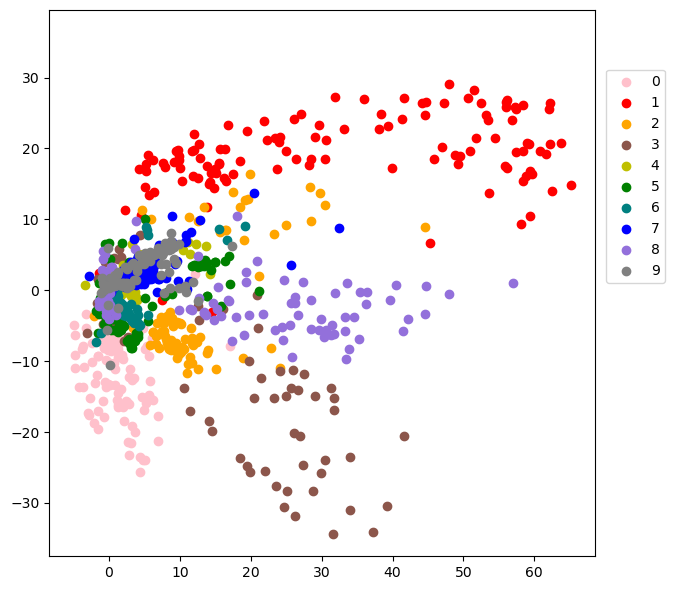

In [19]:
# Use saved model to prevent the latent representation from changing
net = torch.load('autoencoder.pt')
for x, t_class in train_all:
    h = net.encode(x)
plot_latent(h.detach(), t_class)

Text(0.5, 1.0, '[58.0, 25.0]')

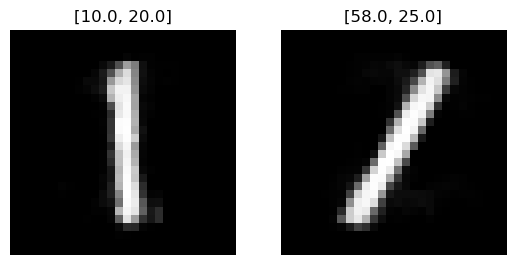

In [20]:
fig = plt.figure()
fig.add_subplot(1, 2, 1)
ds.draw(net.decode(torch.tensor([ 10.0, 20.0])))
plt.title("[10.0, 20.0]")
fig.add_subplot(1, 2, 2)
ds.draw(net.decode(torch.tensor([ 58.0, 25.0])))
plt.title("[58.0, 25.0]")

Text(0.5, 1.0, '[7.0, -1.0]')

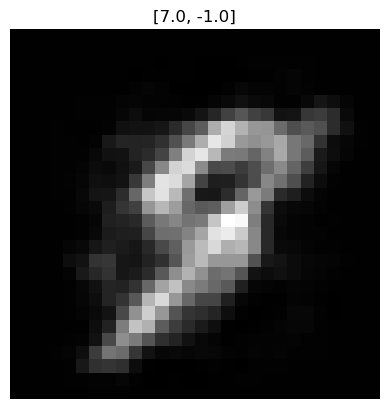

In [21]:
ds.draw(net.decode(torch.tensor([ 7.0, -1.0])))
plt.title("[7.0, -1.0]")

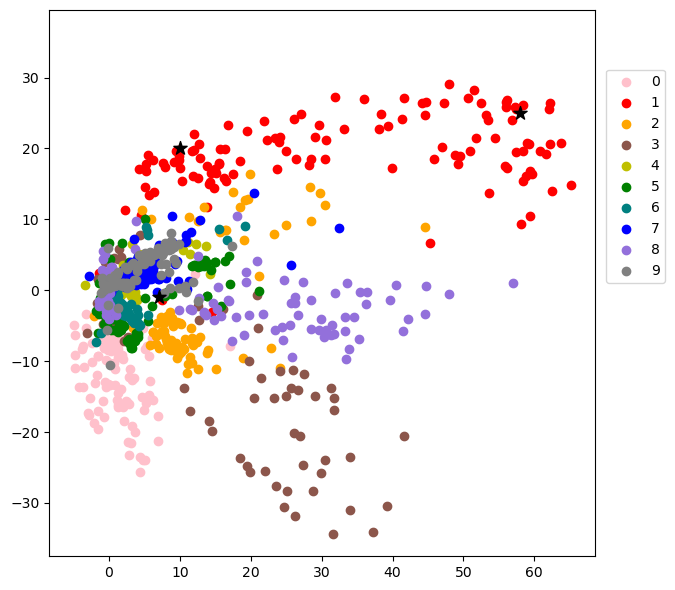

In [22]:
for x, t_class in train_all:
    h = net.encode(x)
plot_latent(h.detach(), t_class)
plt.scatter(10, 20, marker='*', s=100, color='black')
plt.scatter(58, 25, marker='*', s=100, color='black')
plt.scatter(7, -1, marker='*', s=100, color='black')